### In this notebook:
- I first try simple PINN on damped oscillation data. Then I try to use only physics and no data model (goes wrong).
- I then compare simple NN with PINN (basic structure same), PINN performs slightly better, but generalization worse.
- I then try Zero-Shot PINN, with initial condition, Xavier initialization, and no data. It performs very well and generalizes well and exceeds expectations.

- chatgpt chat: https://chatgpt.com/share/685ce951-b18c-800e-87a7-93032ca12e29
- Grok chat: https://grok.com/share/c2hhcmQtMg%3D%3D_a69f2847-5f37-4899-9364-05e98e452e23

In [156]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(53)
np.random.seed(53)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [157]:
class PINN(nn.Module):
    def __init__(self, hidden_layers=2, hidden_neurons=16):
        super(PINN, self).__init__()
        layers = [nn.Linear(3, hidden_neurons), nn.Tanh()]
        for _ in range(hidden_layers - 1):
            layers += [nn.Linear(hidden_neurons, hidden_neurons), nn.Tanh()]
        layers += [nn.Linear(hidden_neurons, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, t, omega, zeta):
        if isinstance(t, np.ndarray):
            t = torch.tensor(t, dtype=torch.float32).to(device)
        if not torch.is_tensor(t): t = torch.tensor(t, dtype=torch.float32).to(device)
        if not torch.is_tensor(omega): omega = torch.tensor(omega, dtype=torch.float32).to(device)
        if not torch.is_tensor(zeta): zeta = torch.tensor(zeta, dtype=torch.float32).to(device)

        omega = omega.expand_as(t)
        zeta = zeta.expand_as(t)
        input_tensor = torch.cat([t, omega, zeta], dim=1)
        return self.net(input_tensor)


In [158]:
class DataNet(nn.Module):
    def __init__(self, hidden_layers=4, hidden_neurons=64):
        super().__init__()
        layers = [nn.Linear(3, hidden_neurons), nn.SiLU()]
        for _ in range(hidden_layers - 1):
            layers += [nn.Linear(hidden_neurons, hidden_neurons), nn.SiLU()]
        layers += [nn.Linear(hidden_neurons, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, t, omega, zeta):
        input_tensor = torch.cat([t, omega, zeta], dim=1)
        return self.net(input_tensor)


In [159]:
def physics_loss(model, t, zeta, omega):
    t.requires_grad_(True)
    omega = omega.expand_as(t)
    zeta = zeta.expand_as(t)
    x = model(t, omega, zeta)

    dx = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
    ddx = torch.autograd.grad(dx, t, grad_outputs=torch.ones_like(dx), create_graph=True)[0]

    res = ddx + 2 * zeta * omega * dx + (omega ** 2) * x
    return torch.mean(res**2)


In [160]:
def modified_physics_loss(model, t, zeta, omega, t0_val=0.0, x0_val=1.0):
    t.requires_grad_(True)
    omega = omega.expand_as(t)
    zeta = zeta.expand_as(t)

    x = model(t, omega, zeta)
    dx = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
    ddx = torch.autograd.grad(dx, t, grad_outputs=torch.ones_like(dx), create_graph=True)[0]

    res = ddx + 2 * zeta * omega * dx + (omega ** 2) * x

    # Initial condition x(0) = x0_val
    t0 = torch.tensor([[t0_val]], dtype=torch.float32, requires_grad=True).to(device)
    omega0 = torch.tensor([[omega[0].item()]], dtype=torch.float32).to(device)
    zeta0 = torch.tensor([[zeta[0].item()]], dtype=torch.float32).to(device)

    x0 = model(t0, omega0, zeta0)
    ic_loss = (x0 - x0_val) ** 2

    return torch.mean(res**2) + ic_loss


In [161]:


# Number of data points
N_data = 100

# Sample t uniformly in [0, 10]
t_data_np = np.random.uniform(0, 10, (N_data, 1))

# Sample ω in [0.8, 1.2] and ζ in [0.05, 0.3]
omega_data_np = np.random.uniform(0.8, 1.2, (N_data, 1))
zeta_data_np  = np.random.uniform(0.05, 0.3, (N_data, 1))

# Analytical solution
def analytical_solution(t, zeta, omega):
    omega_d = omega * np.sqrt(1 - zeta ** 2)
    return np.exp(-zeta * omega * t) * np.cos(omega_d * t)

x_data_np = np.array([
    analytical_solution(t, ζ, ω)
    for t, ζ, ω in zip(t_data_np, zeta_data_np, omega_data_np)
])

# Convert to tensors
t_data    = torch.tensor(t_data_np, dtype=torch.float32).to(device)
x_data    = torch.tensor(x_data_np, dtype=torch.float32).to(device)
omega_data = torch.tensor(omega_data_np, dtype=torch.float32).to(device)
zeta_data  = torch.tensor(zeta_data_np, dtype=torch.float32).to(device)



In [162]:
def train(model, t_phy, omega_phy, zeta_phy, t_data=None, x_data=None, omega_data=None, zeta_data=None,
          epochs=3000, lr=1e-3):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_log = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        phy_loss = modified_physics_loss(model, t_phy, zeta_phy, omega_phy)

        if t_data is not None and x_data is not None:
            pred_data = model(t_data, omega_data, zeta_data)
            data_loss = torch.mean((pred_data - x_data) ** 2)
        else:
            data_loss = 0.0

        loss = phy_loss + data_loss
        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Total Loss: {loss.item():.6f}")

    return loss_log


In [163]:
def train_data_model(model, t, omega, zeta, x, epochs=6000, lr=1e-3):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_log = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        pred = model(t, omega, zeta)
        loss = torch.mean((pred - x) ** 2)
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())

        if epoch % 1000 == 0:
            print(f"[DataNet] Epoch {epoch}, Loss: {loss.item():.6f}")
    return loss_log


In [178]:
N_phy = 10000

t_phy_np = np.random.uniform(0, 10, (N_phy, 1))
omega_phy_np = np.random.uniform(0.5, 2, (N_phy, 1))
zeta_phy_np  = np.random.uniform(0.05, 0.3, (N_phy, 1))

t_phy_only = torch.tensor(t_phy_np, dtype=torch.float32).to(device)
omega_phy_only = torch.tensor(omega_phy_np, dtype=torch.float32).to(device)
zeta_phy_only  = torch.tensor(zeta_phy_np, dtype=torch.float32).to(device)


# Data+Physics PINN
model_dat_phy = PINN(hidden_layers=4, hidden_neurons=64)
t_phy_train = torch.linspace(0, 10, 100).reshape(-1, 1).to(device)

epochs_data = 6000

num_data_points = 1

log1 = train(
    model_dat_phy,
    t_phy_only[:num_data_points], omega_phy_only[:num_data_points], zeta_phy_only[:num_data_points],  # smaller subset for physics part
    t_data=t_data, x_data=x_data,
    omega_data=omega_data, zeta_data=zeta_data,
    epochs=epochs_data
)


torch.save(model_dat_phy.state_dict(), "L_dat_phy.pt")




Epoch 0, Total Loss: 0.996655
Epoch 500, Total Loss: 0.031506
Epoch 1000, Total Loss: 0.027474
Epoch 1500, Total Loss: 0.024952
Epoch 2000, Total Loss: 0.026787
Epoch 2500, Total Loss: 0.019586
Epoch 3000, Total Loss: 0.018334
Epoch 3500, Total Loss: 0.040871
Epoch 4000, Total Loss: 0.015484
Epoch 4500, Total Loss: 0.016483
Epoch 5000, Total Loss: 0.013801
Epoch 5500, Total Loss: 0.028215


In [165]:
model_data_only = DataNet(hidden_layers=4, hidden_neurons=64)

# Take same data points as given to the PINN
t_data_small     = t_data[:num_data_points]
x_data_small     = x_data[:num_data_points]
omega_data_small = omega_data[:num_data_points]
zeta_data_small  = zeta_data[:num_data_points]

log_data_only = train_data_model(
    model_data_only,
    t_data_small, omega_data_small, zeta_data_small, x_data_small,
    epochs=epochs_data
)

torch.save(model_data_only.state_dict(), "L_data_only.pt")



[DataNet] Epoch 0, Loss: 0.118134
[DataNet] Epoch 1000, Loss: 0.000004
[DataNet] Epoch 2000, Loss: 0.000000
[DataNet] Epoch 3000, Loss: 0.000000
[DataNet] Epoch 4000, Loss: 0.000000
[DataNet] Epoch 5000, Loss: 0.000000


In [166]:
# # Physics-Only PINN
# model_phy = PINN(hidden_layers=4, hidden_neurons=64)

# epochs_phy = 20000

# # 10000 random t points for better physics-only learning
# t_phy_only = torch.tensor(np.random.uniform(0, 10, 10000).reshape(-1, 1), dtype=torch.float32).to(device)

# log2 = train(
#     model_phy,
#     t_phy_only, omega_phy_only, zeta_phy_only,
#     epochs=epochs_phy
# )

# torch.save(model_phy.state_dict(), "L_phy.pt")

In [175]:
# # Test for training parameters (ω=1.0, ζ=0.1)
# omega_test = torch.full((200, 1), 1.0).to(device)
# zeta_test = torch.full((200, 1), 0.1).to(device)
# t_test = torch.linspace(0, 10, 200).reshape(-1, 1).to(device)

# true_vals = torch.tensor(
#     analytical_solution(t_test.cpu().numpy(), 0.1, 1.0),
#     dtype=torch.float32
# ).to(device)

# with torch.no_grad():
#     pred1 = model_dat_phy(t_test, omega_test, zeta_test)
#     # pred2 = model_phy(t_test, omega_test, zeta_test)

# plt.figure(figsize=(10, 5))
# plt.plot(t_test.cpu(), true_vals.cpu(), label="True")
# plt.plot(t_test.cpu(), pred1.cpu(), '--', label="Data+Physics PINN")
# # plt.plot(t_test.cpu(), pred2.cpu(), ':', label="Physics-Only PINN")
# plt.legend()
# plt.title("Training Region Performance")
# plt.show()


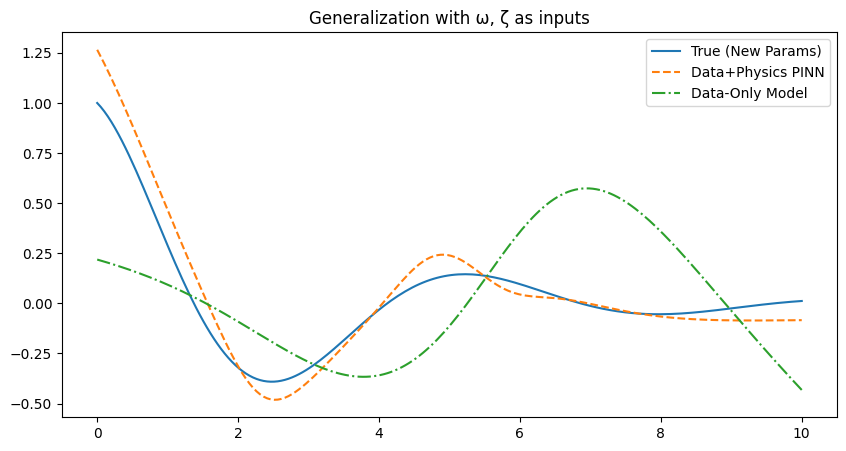

In [177]:
omega_test = torch.full((200, 1), 1.2).to(device)
zeta_test = torch.full((200, 1), 0.3).to(device)
t_test_new = torch.linspace(0, 10, 200).reshape(-1, 1).to(device)

true_vals_new = torch.tensor(analytical_solution(t_test_new.cpu().numpy(), 0.3, 1.2), dtype=torch.float32).to(device)

with torch.no_grad():
    pred1_new = model_dat_phy(t_test_new, omega_test, zeta_test)
    # pred2_new = model_phy(t_test_new, omega_test, zeta_test)
    pred1_new_datOnly = model_data_only(t_test_new, omega_test, zeta_test)

plt.figure(figsize=(10, 5))
plt.plot(t_test_new.cpu(), true_vals_new.cpu(), label="True (New Params)")
plt.plot(t_test_new.cpu(), pred1_new.cpu(), '--', label="Data+Physics PINN")
# plt.plot(t_test_new.cpu(), pred2_new.cpu(), ':', label="Physics-Only PINN")
plt.plot(t_test_new.cpu(), pred1_new_datOnly.cpu(), '-.', label="Data-Only Model")
plt.plot()
plt.legend()
plt.title("Generalization with ω, ζ as inputs")
plt.show()


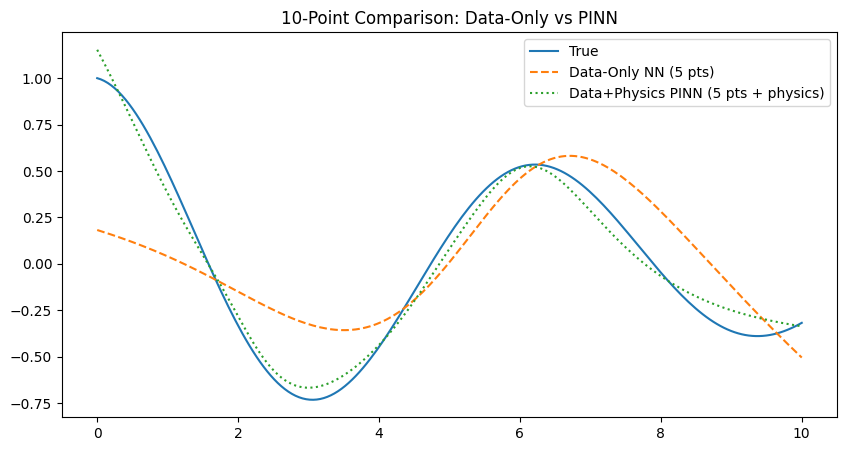

In [174]:
# Fixed ω, ζ for evaluation
t_test = torch.linspace(0, 10, 200).reshape(-1, 1).to(device)
omega_test = torch.full_like(t_test, 1.0)
zeta_test  = torch.full_like(t_test, 0.1)

true_vals = torch.tensor(
    analytical_solution(t_test.cpu().numpy(), 0.1, 1.0),
    dtype=torch.float32
).to(device)

with torch.no_grad():
    pred_data_only = model_data_only(t_test, omega_test, zeta_test)
    pred_dat_phy   = model_dat_phy(t_test, omega_test, zeta_test)

plt.figure(figsize=(10, 5))
plt.plot(t_test.cpu(), true_vals.cpu(), label="True")
plt.plot(t_test.cpu(), pred_data_only.cpu(), '--', label=f"Data-Only NN ({num_data_points} pts)")
plt.plot(t_test.cpu(), pred_dat_phy.cpu(), ':', label=f"Data+Physics PINN ({num_data_points} pts + physics)")
plt.title("10-Point Comparison: Data-Only vs PINN")
plt.legend()
plt.show()


In [170]:
# Set seed for reproducibility
np.random.seed(53)

N_test = 200  # number of test points

t_test_rand_np     = np.random.uniform(0, 10, (N_test, 1))
omega_test_rand_np = np.random.uniform(1.8, 3.0, (N_test, 1))   # outside training range
zeta_test_rand_np  = np.random.uniform(0.3, 0.5, (N_test, 1))   # outside training range

# Ground truth from analytical solution
x_test_rand_np = np.array([
    analytical_solution(t, ζ, ω)
    for t, ζ, ω in zip(t_test_rand_np, zeta_test_rand_np, omega_test_rand_np)
])

# Convert to tensors
t_test_rand     = torch.tensor(t_test_rand_np, dtype=torch.float32).to(device)
omega_test_rand = torch.tensor(omega_test_rand_np, dtype=torch.float32).to(device)
zeta_test_rand  = torch.tensor(zeta_test_rand_np, dtype=torch.float32).to(device)
x_test_rand     = torch.tensor(x_test_rand_np, dtype=torch.float32).to(device)


In [171]:
with torch.no_grad():
    pred_data_only_rand = model_data_only(t_test_rand, omega_test_rand, zeta_test_rand)
    pred_dat_phy_rand   = model_dat_phy(t_test_rand, omega_test_rand, zeta_test_rand)


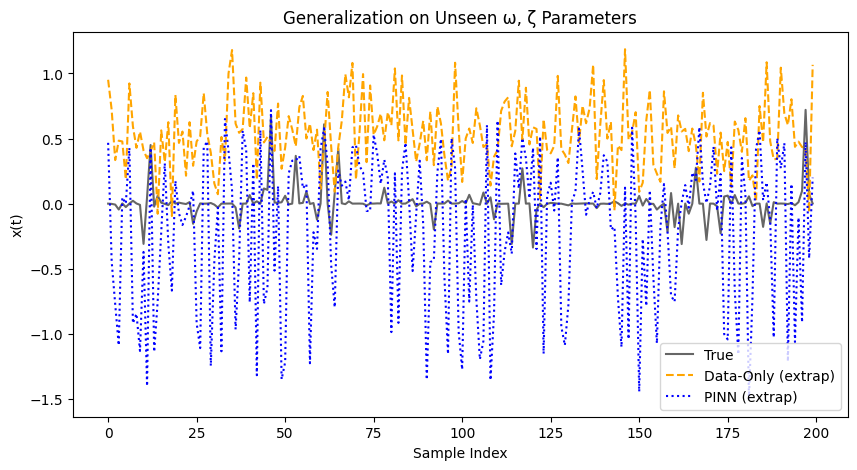

In [172]:
plt.figure(figsize=(10, 5))
plt.plot(x_test_rand.cpu().numpy(), label='True', color='black', alpha=0.6)
plt.plot(pred_data_only_rand.cpu().numpy(), '--', label='Data-Only (extrap)', color='orange')
plt.plot(pred_dat_phy_rand.cpu().numpy(), ':', label='PINN (extrap)', color='blue')
plt.title("Generalization on Unseen ω, ζ Parameters")
plt.xlabel("Sample Index")
plt.ylabel("x(t)")
plt.legend()
plt.show()




In [173]:
from sklearn.metrics import root_mean_squared_error

rmse_data_only = root_mean_squared_error(x_test_rand.cpu().numpy(), pred_data_only_rand.cpu().numpy())
rmse_dat_phy = root_mean_squared_error(x_test_rand.cpu().numpy(), pred_dat_phy_rand.cpu().numpy())
print(f"RMSE Data-Only Model: {rmse_data_only:.4f}")
print(f"RMSE Data+Physics PINN: {rmse_dat_phy:.4f}")


RMSE Data-Only Model: 0.6033
RMSE Data+Physics PINN: 0.6187


# ZERO SHOT PINN

In [179]:
class PINN_ZS(nn.Module):
    def __init__(self, hidden_layers=4, hidden_neurons=64):
        super().__init__()
        layers = [nn.Linear(3, hidden_neurons), nn.SiLU()]
        for _ in range(hidden_layers - 1):
            layers += [nn.Linear(hidden_neurons, hidden_neurons), nn.SiLU()]
        layers += [nn.Linear(hidden_neurons, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, t, omega, zeta):
        input_tensor = torch.cat([t, omega, zeta], dim=1)
        return self.net(input_tensor)


In [200]:
# Constants
num_dat_pt_zs = 1
np.random.seed(53)

t_zs_np     = np.random.uniform(0, 3, (num_dat_pt_zs, 1))
omega_zs_np = np.random.uniform(1.0, 2.5, (num_dat_pt_zs, 1))
zeta_zs_np  = np.random.uniform(0.1, 0.4, (num_dat_pt_zs, 1))

# Compute ground truth
x_zs_np = np.array([
    analytical_solution(t, ζ, ω)
    for t, ζ, ω in zip(t_zs_np, zeta_zs_np, omega_zs_np)
])

# Convert to tensors (but don’t use x_zs in training!)
t_zs     = torch.tensor(t_zs_np, dtype=torch.float32).to(device)
omega_zs = torch.tensor(omega_zs_np, dtype=torch.float32).to(device)
zeta_zs  = torch.tensor(zeta_zs_np, dtype=torch.float32).to(device)
x_true_zs = torch.tensor(x_zs_np, dtype=torch.float32).to(device)


In [201]:
def physics_loss_only(model, t, omega, zeta):
    t.requires_grad_(True)
    x = model(t, omega, zeta)
    dx = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
    ddx = torch.autograd.grad(dx, t, grad_outputs=torch.ones_like(dx), create_graph=True)[0]
    residual = ddx + 2 * zeta * omega * dx + (omega**2) * x

    loss_reg = torch.mean(torch.relu(0.05 - torch.abs(x)))
    λ_reg = 100  # Regularization coefficient
    total_loss = residual + λ_reg * loss_reg

    return torch.mean(residual**2)


In [202]:
def train_pinn_zs(model, t, omega, zeta, num_epochs_zs=5000, lr=1e-3):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs_zs):
        optimizer.zero_grad()
        loss = physics_loss_only(model, t, omega, zeta)
        loss.backward()
        optimizer.step()

        if epoch % 1000 == 0:
            print(f"[PINN-ZS] Epoch {epoch}, Physics Loss: {loss.item():.6f}")
    return model


In [203]:
# Train
model_zs = PINN_ZS(hidden_layers=4, hidden_neurons=64)
model_zs = train_pinn_zs(model_zs, t_zs, omega_zs, zeta_zs, num_epochs_zs=3000)

# Predict
with torch.no_grad():
    x_pred_zs = model_zs(t_zs, omega_zs, zeta_zs)

# Save for later analysis
x_pred_list = x_pred_zs.cpu().numpy().tolist()
x_true_list = x_true_zs.cpu().numpy().tolist()


[PINN-ZS] Epoch 0, Physics Loss: 0.058832
[PINN-ZS] Epoch 1000, Physics Loss: 0.000000
[PINN-ZS] Epoch 2000, Physics Loss: 0.000000
[PINN-ZS] Epoch 3000, Physics Loss: 0.000000
[PINN-ZS] Epoch 4000, Physics Loss: 0.000000
[PINN-ZS] Epoch 5000, Physics Loss: 0.000000


- ### **The Above solution does not work as intended, goes to trivial solution**

## Preventing Trivial Solution

- Generated by Grok
- Avoids trivial solutions by enforcing initial conditions and Xavier initialization

In [229]:
import torch
import torch.nn as nn
import numpy as np

class PINN_ZS(nn.Module):
    def __init__(self, hidden_layers=4, hidden_neurons=64):
        super().__init__()
        layers = [nn.Linear(3, hidden_neurons), nn.Tanh()]  # Changed to Tanh for oscillatory behavior
        for _ in range(hidden_layers - 1):
            layers += [nn.Linear(hidden_neurons, hidden_neurons), nn.Tanh()]
        layers += [nn.Linear(hidden_neurons, 1)]
        self.net = nn.Sequential(*layers)
        
        # Xavier initialization to avoid trivial solution
        for layer in self.net:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.normal_(layer.bias, mean=0.0, std=0.1)

    def forward(self, t, omega, zeta):
        input_tensor = torch.cat([t, omega, zeta], dim=1)
        return self.net(input_tensor)

#=======================================================

# Constants
num_dat_pt_zs = 100
np.random.seed(42)

t_zs_np     = np.random.uniform(0, 10, (num_dat_pt_zs, 1))
t_zs_np = np.sort(t_zs_np, axis=0)
# omega_zs_np = np.random.uniform(1.0, 1, (num_dat_pt_zs, 1))
# zeta_zs_np  = np.random.uniform(0.1, 0.4, (num_dat_pt_zs, 1))
# fix ω and ζ for testing
omega_zs_np = np.full((num_dat_pt_zs, 1), 1.2)  # Fixed ω
zeta_zs_np  = np.full((num_dat_pt_zs, 1), 0.3)  # Fixed ζ


# Compute ground truth
x_zs_np = np.array([
    analytical_solution(t, ζ, ω)
    for t, ζ, ω in zip(t_zs_np, zeta_zs_np, omega_zs_np)
])

# Convert to tensors (but don’t use x_zs in training!)
t_zs     = torch.tensor(t_zs_np, dtype=torch.float32).to(device)
omega_zs = torch.tensor(omega_zs_np, dtype=torch.float32).to(device)
zeta_zs  = torch.tensor(zeta_zs_np, dtype=torch.float32).to(device)
x_true_zs = torch.tensor(x_zs_np, dtype=torch.float32).to(device)

# Initial condition tensors (for t=0)
t_ic = torch.zeros_like(t_zs, requires_grad=True).to(device)
x_ic = torch.tensor([[1.0]], dtype=torch.float32).to(device)  # Non-zero initial position
v_ic = torch.tensor([[0.0]], dtype=torch.float32).to(device)  # Initial velocity

#=======================================================

def physics_loss_only(model, t, omega, zeta, t_ic, x_ic, v_ic):
    t.requires_grad_(True)
    x = model(t, omega, zeta)
    dx = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
    ddx = torch.autograd.grad(dx, t, grad_outputs=torch.ones_like(dx), create_graph=True)[0]
    residual = ddx + 2 * zeta * omega * dx + (omega**2) * x
    
    # Initial condition loss
    x_pred_ic = model(t_ic, omega, zeta)
    dx_ic = torch.autograd.grad(x_pred_ic, t_ic, grad_outputs=torch.ones_like(x_pred_ic), create_graph=True)[0]
    loss_ic = torch.mean((x_pred_ic - x_ic)**2) + torch.mean((dx_ic - v_ic)**2)
    
    # L2 regularization
    l2_reg = sum(torch.mean(param**2) for param in model.parameters())
    
    # Physics loss with normalization
    loss_pde = torch.mean(residual**2) / (torch.mean(x**2) + 1e-6)
    
    # Combine losses with weights
    λ_ic = 100.0  # High weight for initial conditions
    λ_reg = 0.01  # Regularization weight
    total_loss = loss_pde + λ_ic * loss_ic + λ_reg * l2_reg
    
    return total_loss

#=======================================================

def train_pinn_zs(model, t, omega, zeta, t_ic, x_ic, v_ic, num_epochs_zs=5000, lr=1e-3):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs_zs)  # Learning rate scheduling
    
    for epoch in range(num_epochs_zs):
        optimizer.zero_grad()
        loss = physics_loss_only(model, t, omega, zeta, t_ic, x_ic, v_ic)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        if epoch % 1000 == 0:
            print(f"[PINN-ZS] Epoch {epoch}, Total Loss: {loss.item():.6f}")
    return model

#=======================================================

# Train
model_zs = PINN_ZS(hidden_layers=4, hidden_neurons=64)
model_zs = train_pinn_zs(model_zs, t_zs, omega_zs, zeta_zs, t_ic, x_ic, v_ic, num_epochs_zs=10000)

# Predict
with torch.no_grad():
    x_pred_zs = model_zs(t_zs, omega_zs, zeta_zs)

# Save for later analysis
x_pred_list = x_pred_zs.cpu().numpy().tolist()
x_true_list = x_true_zs.cpu().numpy().tolist()

[PINN-ZS] Epoch 0, Total Loss: 232.579834
[PINN-ZS] Epoch 1000, Total Loss: 0.017864
[PINN-ZS] Epoch 2000, Total Loss: 0.012507
[PINN-ZS] Epoch 3000, Total Loss: 0.009646
[PINN-ZS] Epoch 4000, Total Loss: 0.059122
[PINN-ZS] Epoch 5000, Total Loss: 0.004077
[PINN-ZS] Epoch 6000, Total Loss: 0.002945
[PINN-ZS] Epoch 7000, Total Loss: 0.002716
[PINN-ZS] Epoch 8000, Total Loss: 0.002658
[PINN-ZS] Epoch 9000, Total Loss: 0.002633


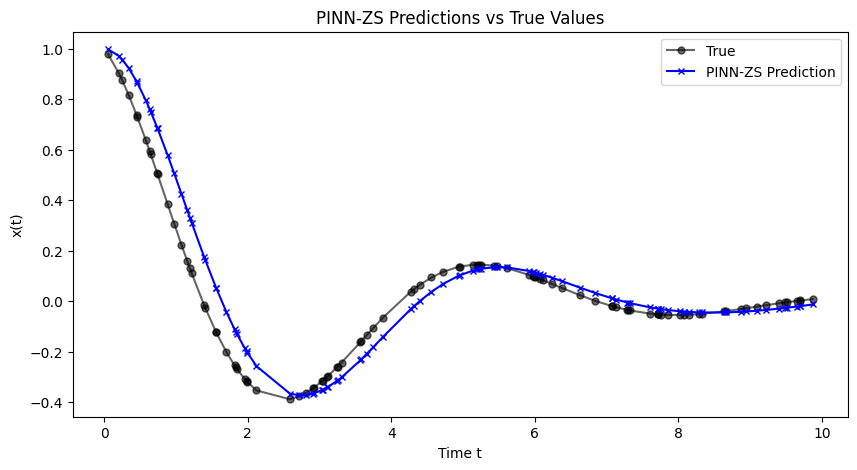

PINN-ZS Prediction at t=0.05522117123602399: 0.9979
True Value at t=0.05522117123602399: 0.9784


In [230]:
# plot x_pred_list
plt.figure(figsize=(10, 5))
plt.plot(t_zs_np, x_true_list, label='True', color='black',
            alpha=0.6, marker='o', markersize=5)
plt.plot(t_zs_np, x_pred_list, label='PINN-ZS Prediction', color='blue',
            marker='x', markersize=5)
plt.title("PINN-ZS Predictions vs True Values")
plt.xlabel("Time t")
plt.ylabel("x(t)")
plt.legend()
plt.show()

print(f"PINN-ZS Prediction at t={t_zs_np[0][0]}: {x_pred_list[0][0]:.4f}")
print(f"True Value at t={t_zs_np[0][0]}: {x_true_list[0][0]:.4f}")


In [228]:
import numpy as np

x_pred_np = np.array(x_pred_list)
x_true_np = np.array(x_true_list)

rmse_zs = np.sqrt(np.mean((x_pred_np - x_true_np) ** 2))
print(f"Zero-Shot PINN RMSE: {rmse_zs:.5f}")


Zero-Shot PINN RMSE: 0.05874


### **Success likely stems from: proper initialization (Xavier), enforced initial conditions, Tanh activation for oscillations, balanced loss terms (PDE, IC, regularization), and learning rate scheduling.**

### **Observations:** This ZS method can generalize much better than data+physics model.